In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import library

In [ ]:
import tensorflow as tf
import numpy as np
import glob as gl
import matplotlib.pyplot as plt
import cv2
import random
from keras import backend as K
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import confusion_matrix

Data augmentation

In [ ]:
def augment_data(image, mask, flip_ud=False, flip_lr=False):
  if(np.random.random() > 0.5):
    flip_ud = True
    # Flip vertically
    if flip_ud and np.random.random() > 0.5:
        image = cv2.flip(image, 0)
        mask = cv2.flip(mask, 0)
    return image, mask
  elif (np.random.random() < 0.5):
    flip_lr = True
    # Flip horizontally
    if flip_lr and np.random.random() > 0.5:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)
    return image, mask
  else:
    return image, mask


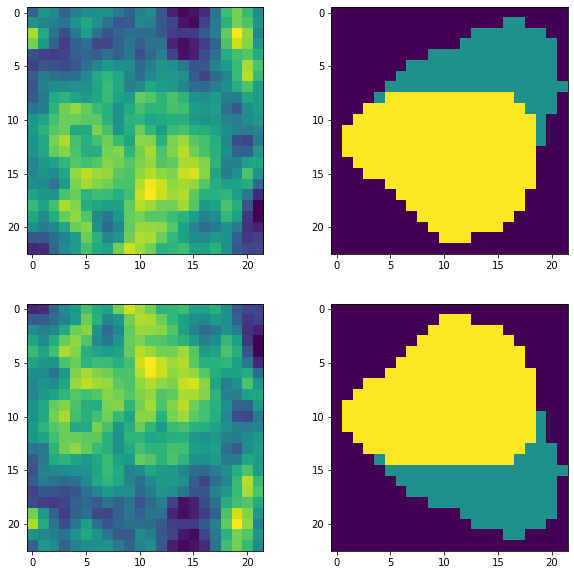

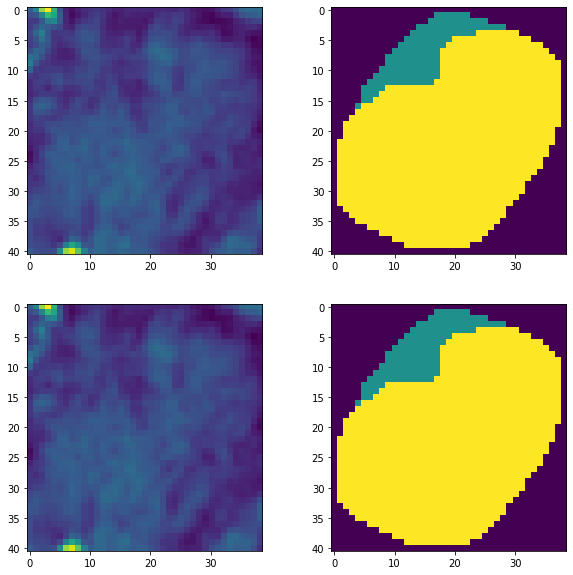

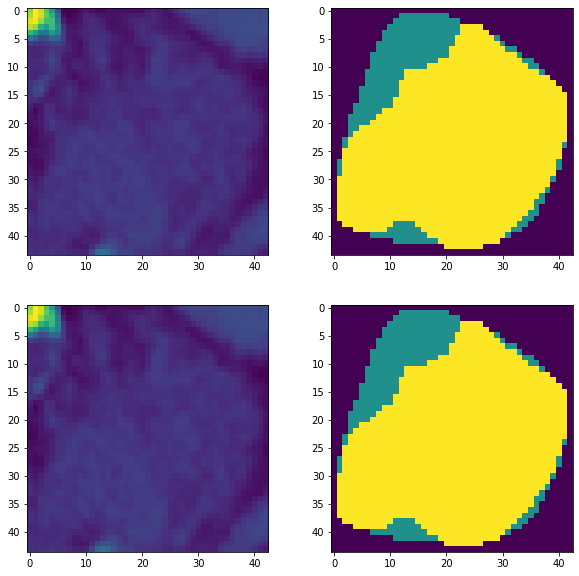

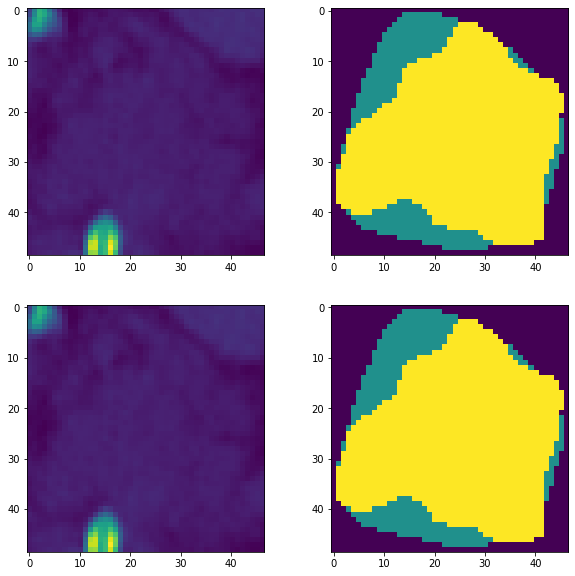

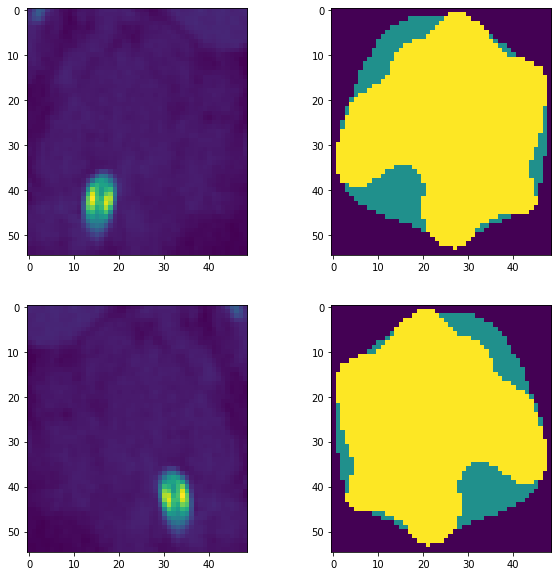

In [ ]:
for i in range(0, 5):  
  image = np.load('/content/drive/MyDrive/research/image/image_'+str(i)+'.npy')
  label = np.load('/content/drive/MyDrive/research/label/label_'+str(i)+'.npy')
  img, lbl = augment_data(image, label)
  plt.figure(figsize=(10, 10))
  plt.subplot(2, 2, 1)
  plt.imshow(image[:, :])
  plt.subplot(2, 2, 2)
  plt.imshow(label[:, :])
  plt.subplot(2, 2, 3)
  plt.imshow(img[:, :])
  plt.subplot(2, 2, 4)
  plt.imshow(lbl[:, :])
  plt.show()

Dice loss function

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

Fine tuning U-net model

In [ ]:
def unet(height, width, channel, n_class):
    inputs = tf.keras.layers.Input((height, width, channel))
    
    # Encoder part
    c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Decode part
    u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.1)(c6)
    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.1)(c7)
    c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(n_class, (1, 1), activation='softmax')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model



In [ ]:
model = unet(128, 128, 1, 3)
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 1)
(None, 128, 128, 3)


One hot-encoding for mask and create an pipline 

In [ ]:
def one_hot_encode(mask):
    one_hot_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] == 0:
                one_hot_mask[i][j][0] = 1
            elif mask[i][j] == 1:
                one_hot_mask[i][j][1] = 1
            elif mask[i][j] == 2:
                one_hot_mask[i][j][2] = 1
    return one_hot_mask

def generator(dir_images, dir_masks, batch_size, train=False):
    while True:
        for i in range(0, len(dir_images), batch_size):
            image_array = []
            mask_array = []
            for i, j in zip(dir_images[i:i + batch_size], dir_masks[i:i + batch_size]):
              load_image = np.load(i)
              load_mask = np.load(j)
              if(train == True):
                img, msk = augment_data(load_image, load_mask, flip_ud=False, flip_lr=False)
                image_array.append(img)
                mask_array.append(msk)
              else:
                image_array.append(load_image)
                mask_array.append(load_mask)
                
            x_batch = [np.expand_dims(cv2.resize(image, (128, 128)), axis = -1) for image in image_array]
            y_batch = [cv2.resize(mask, (128, 128)) for mask in mask_array]
            one_hot_y_batch = [one_hot_encode(mask) for mask in y_batch]
            yield (np.array(x_batch), np.array(one_hot_y_batch))

In [ ]:
path_image = '/content/drive/MyDrive/research/image/*'
path_label = '/content/drive/MyDrive/research/label/*'

In [ ]:
dir_images = []
dir_masks = []
for i in sorted(gl.glob(path_image)):
  dir_images.append(i)
for i in sorted(gl.glob(path_label)):
  dir_masks.append(i)

In [ ]:
print(len(dir_images))
print(len(dir_masks))

2529
2529


Shuffle image and mask corresponding

In [ ]:
indices = list(range(len(dir_images)))
random.shuffle(indices)

In [ ]:
shuffle_dir_images = [dir_images[i] for i in indices]
shuffle_dir_masks = [dir_masks[i] for i in indices]

In [ ]:
for i, j in zip(shuffle_dir_images, shuffle_dir_masks):
  print(i, j)

/content/drive/MyDrive/research/image/image_254.npy /content/drive/MyDrive/research/label/label_254.npy
/content/drive/MyDrive/research/image/image_647.npy /content/drive/MyDrive/research/label/label_647.npy
/content/drive/MyDrive/research/image/image_1142.npy /content/drive/MyDrive/research/label/label_1142.npy
/content/drive/MyDrive/research/image/image_1319.npy /content/drive/MyDrive/research/label/label_1319.npy
/content/drive/MyDrive/research/image/image_1253.npy /content/drive/MyDrive/research/label/label_1253.npy
/content/drive/MyDrive/research/image/image_719.npy /content/drive/MyDrive/research/label/label_719.npy
/content/drive/MyDrive/research/image/image_550.npy /content/drive/MyDrive/research/label/label_550.npy
/content/drive/MyDrive/research/image/image_625.npy /content/drive/MyDrive/research/label/label_625.npy
/content/drive/MyDrive/research/image/image_1856.npy /content/drive/MyDrive/research/label/label_1856.npy
/content/drive/MyDrive/research/image/image_1754.npy /co

In [ ]:
#divide 20% for test set and 80% for valid, train set
train_images = shuffle_dir_images[:int(0.6 * len(shuffle_dir_images))]
val_images = shuffle_dir_images[int(0.6 * len(shuffle_dir_images)):int(0.8 * len(shuffle_dir_images))]
test_images = shuffle_dir_images[int(0.8 * len(shuffle_dir_images)):]

train_masks = shuffle_dir_masks[:int(0.6 * len(shuffle_dir_masks))]
val_masks = shuffle_dir_masks[int(0.6 * len(shuffle_dir_masks)):int(0.8 * len(shuffle_dir_masks))]
test_masks = shuffle_dir_masks[int(0.8 * len(shuffle_dir_masks)):]

train_gen = generator(train_images, train_masks, batch_size=32, train=True)
val_gen = generator(val_images, val_masks, batch_size=32, train=False)
test_gen = generator(test_images, test_masks, batch_size=32, train=False)

In [ ]:
x_batch, y_batch = next(train_gen)
print(x_batch.shape)
print(y_batch.shape)

(32, 128, 128, 1)
(32, 128, 128, 3)


In [ ]:
#Checkpoint and Early stopping
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/research/next_final.h5', save_best_only=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

#early_stop= tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', mode='min')

In [ ]:
model.compile(optimizer = 'adam', loss = dice_coef_loss, metrics = [dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
#training
history = model.fit(train_gen,
                    steps_per_epoch=len(train_images) // 32,
                    epochs=50,
                    validation_data=val_gen,
                    callbacks = [checkpointer],
                    validation_steps=len(val_images) // 32,
                    shuffle = True)

Epoch 1/50
47/47 [==============================] - 388s 8s/step - loss: 0.2365 - dice_coef: 0.7635 - val_loss: 0.2076 - val_dice_coef: 0.7924
Epoch 2/50
47/47 [==============================] - 55s 1s/step - loss: 0.2021 - dice_coef: 0.7979 - val_loss: 0.1861 - val_dice_coef: 0.8139
Epoch 3/50
47/47 [==============================] - 55s 1s/step - loss: 0.1869 - dice_coef: 0.8131 - val_loss: 0.1840 - val_dice_coef: 0.8160
Epoch 4/50
47/47 [==============================] - 55s 1s/step - loss: 0.1702 - dice_coef: 0.8298 - val_loss: 0.1744 - val_dice_coef: 0.8256
Epoch 5/50
47/47 [==============================] - 56s 1s/step - loss: 0.1593 - dice_coef: 0.8407 - val_loss: 0.1629 - val_dice_coef: 0.8371
Epoch 6/50
47/47 [==============================] - 57s 1s/step - loss: 0.1521 - dice_coef: 0.8479 - val_loss: 0.1446 - val_dice_coef: 0.8554
Epoch 7/50
47/47 [==============================] - 56s 1s/step - loss: 0.1444 - dice_coef: 0.8556 - val_loss: 0.1381 - val_dice_coef: 0.8619
Epoch

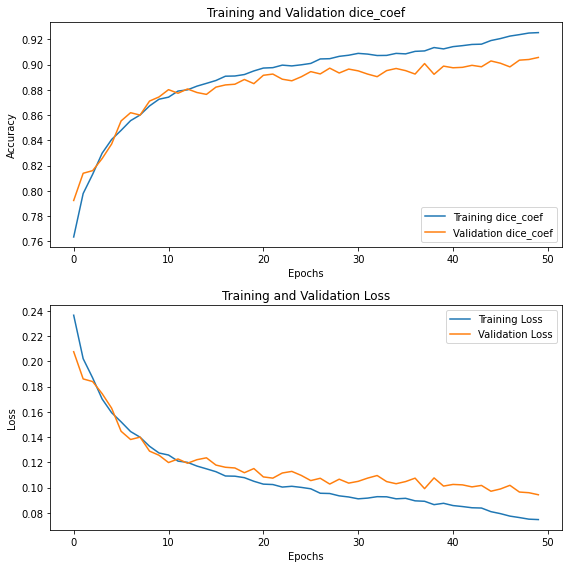

In [ ]:
#visualize result
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(epochs_range, acc, label='Training dice_coef')
plt.plot(epochs_range, val_acc, label='Validation dice_coef')
plt.legend(loc='lower right')
plt.title('Training and Validation dice_coef')

plt.subplot(2, 1, 2)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()

plt.show()

Import csv library and save test set for check accuracy 

In [ ]:
import csv
csv_file = '/content/drive/MyDrive/research/save_test.csv'  

In [ ]:
# Open the CSV file in write mode
with open(csv_file, "w", newline="") as file:
    # Create a CSV writer object
    writer = csv.writer(file)
    
    # Write the column headers to the CSV file
    writer.writerow(["Mask", "Image"])
    
    # Write each mask and image path to a new row in the CSV file
    for mask_path, image_path in zip(test_masks, test_images):
        writer.writerow([mask_path, image_path])


In [ ]:
import keras
model = keras.models.load_model("/content/drive/MyDrive/research/next_final.h5", custom_objects={"dice_coef_loss": dice_coef_loss, "dice_coef": dice_coef})

In [ ]:
import csv

masks = []
images = []
with open('/content/drive/MyDrive/research/save_test.csv', 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
      masks.append(row['Mask'])
      images.append(row['Image'])

In [ ]:
list_image = []
list_mask = []
for image in images:
  img = np.load(image)
  img = cv2.resize(img, (128, 128))
  img = tf.expand_dims(img, axis = -1)
  list_image.append(img)

for mask in masks:
  msk = np.load(mask)
  msk = cv2.resize(msk, (128, 128))
  msk = one_hot_encode(msk)
  list_mask.append(msk)

In [ ]:
list_image = np.array(list_image)
list_mask = np.array(list_mask)
print(list_image.shape)
print(list_mask.shape)

(506, 128, 128, 1)
(506, 128, 128, 3)


In [ ]:
list_predict = model.predict(list_image)
list_predict = np.round(list_predict)
print(list_predict.shape)

16/16 [==============================] - 49s 3s/step
(506, 128, 128, 3)


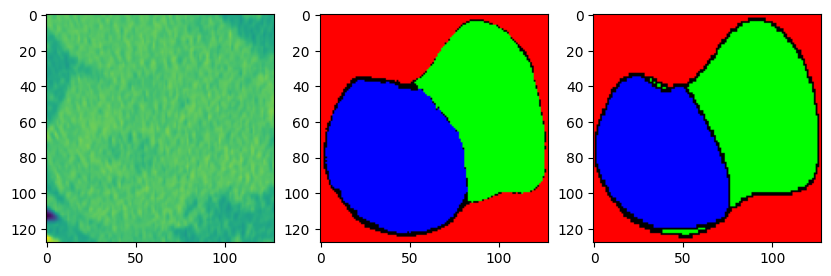

In [ ]:
plt.figure(figsize = (10, 10))
plt.subplot(1, 3, 1)
plt.imshow(list_image[14, :, :, :])
plt.subplot(1, 3, 2)
plt.imshow(list_predict[14, :, :, :])
plt.subplot(1, 3, 3)
plt.imshow(list_mask[14, :, :, :])
plt.show()

In [ ]:
#Evaluate using confusion_matrix for tumor and pancreas
def confusion_matrix_(num_channel, mask, pred):
  channel_true = mask[:, :, num_channel]
  channel_pred = pred[:, :, num_channel]
  y_true = channel_true.flatten()
  y_pred = channel_pred.flatten()
  cm = confusion_matrix(y_true, y_pred)
  TP = cm[0, 0]
  FP = cm[0, 1]
  FN = cm[1, 0]
  TN = cm[1, 1]
  return TP, TN, FP, FN

In [ ]:
TP_ARR = []
TN_ARR = []
FP_ARR = []
FN_ARR = []
for i in range(list_mask.shape[0]):
  mask = list_mask[i, :, :, :]
  pred = list_predict[i, :, :, :]
  TP, TN, FP, FN = confusion_matrix_(1, mask, pred)
  TP_ARR.append(TP)
  TN_ARR.append(TN)
  FP_ARR.append(FP)
  FN_ARR.append(FN)

In [ ]:
def Dice_similarity_coefficient(TP, FP, FN):
  DSC = 2 * TP / (2 * TP + FP + FN)
  return DSC
def Sensitive(TP, FN):
  SEN = TP / (TP + FN)
  return SEN
def Accuracy(TP, TN, FP, FN):
  Acc = (TP + TN) / (TP + TN + FP + FN)
  return Acc
def Precision(TP, FP):
  Pre = TP / (TP + FP)
  return Pre
def mean_IOU_score(TP, FP, FN):
  Mean_Iou = TP / (TP + FP + FN)
  return Mean_Iou 

In [ ]:
for i in range(5, 15):
  TP, TN, FP, FN = confusion_matrix_(1, list_mask[i], list_predict[i])
  print("Mean IOU" + str(i) + " = ", Dice_similarity_coefficient(TP, FP, FN))
  #print("Mean IOU" + str(i) + " = ",mean_IOU_score(TP, FP, FN))

Mean IOU5 =  0.8664181292673732
Mean IOU6 =  0.9370876531573987
Mean IOU7 =  0.9669925244393329
Mean IOU8 =  0.8425551057130004
Mean IOU9 =  0.914262374215588
Mean IOU10 =  0.9263053943957537
Mean IOU11 =  0.9432257416796346
Mean IOU12 =  0.8300282191039469
Mean IOU13 =  0.8530089628681178
Mean IOU14 =  0.9672777705543276


In [ ]:
TP = np.mean(TP_ARR)
TN = np.mean(TN_ARR)
FP = np.mean(FP_ARR)
FN = np.mean(FN_ARR)
Dice_average = Dice_similarity_coefficient(TP, FP, FN)
Sen = Sensitive(TP, FN)
Acc = Accuracy(TP, TN, FP, FN)
Pre = Precision(TP, FP)
Iou = mean_IOU_score(TP, FP, FN)
print('Dice_average_of_pancreas = ', Dice_average)
print('Sensitive_of_pancreas = ', Sen)
print('Accuracy_of_pancreas = ', Acc)
print('Precision_of_pancreas = ', Pre)
print('Mean IOU of pancreas', Iou)

Dice_average_of_pancreas =  0.8898503095801623
Sensitive_of_pancreas =  0.9192281858993024
Accuracy_of_pancreas =  0.8490701909121787
Precision_of_pancreas =  0.8622920708353472
Mean IOU of pancreas 0.8015588503597542


In [ ]:
TP_ARR_1 = []
TN_ARR_1 = []
FP_ARR_1 = []
FN_ARR_1 = []
for i in range(list_mask.shape[0]):
  mask = list_mask[i, :, :, :]
  pred = list_predict[i, :, :, :]
  TP, TN, FP, FN = confusion_matrix_(2, mask, pred)
  TP_ARR_1.append(TP)
  TN_ARR_1.append(TN)
  FP_ARR_1.append(FP)
  FN_ARR_1.append(FN)

In [ ]:
TP_1 = np.mean(TP_ARR_1)
TN_1 = np.mean(TN_ARR_1)
FP_1 = np.mean(FP_ARR_1)
FN_1 = np.mean(FN_ARR_1)
Dice_average_1 = Dice_similarity_coefficient(TP_1, FP_1, FN_1)
Sen_1 = Sensitive(TP_1, FN_1)
Acc_1 = Accuracy(TP_1, TN_1, FP_1, FN_1)
Pre_1 = Precision(TP_1, FP_1)
Iou_1 = mean_IOU_score(TP_1, FP_1, FN_1)
print('Dice_avegare_of_tumor = ', Dice_average_1)
print('Sensitive_of_tumor = ', Sen_1)
print('Accuracy_of_tumor = ', Acc_1)
print('Precision_of_tumor = ', Pre_1)
print('Mean IOU of tumor', Iou_1)

Dice_avegare_of_tumor =  0.9530798242518459
Sensitive_of_tumor =  0.9517385770006476
Accuracy_of_tumor =  0.9220245723196641
Precision_of_tumor =  0.9544248571706435
Mean IOU of tumor 0.9103653232881412
